In [4]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as functional
import matplotlib.pyplot as plt
from transformers import BertForSequenceClassification, AdamW, BertConfig
import gc
from transformers import BertModel
from sklearn.metrics import roc_auc_score,f1_score
import time
import datetime
from bs4 import BeautifulSoup
import re,string,unicodedata
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
fake = pd.read_csv('/content/drive/MyDrive/thesis-data/Fake.csv')
true = pd.read_csv('/content/drive/MyDrive/thesis-data/True.csv')

In [7]:
fake["label"] = 0
true["label"] = 1

In [8]:
df = pd.concat([fake, true], ignore_index = True)

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

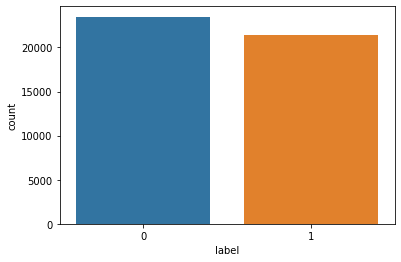

In [9]:
sns.countplot(df.label)

In [10]:
df.isna().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

In [11]:
df.subject.value_counts()

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

In [12]:
df['text'] = df['title'] + " " + df['text']
df.drop(columns=['title', 'date', 'subject'], inplace = True)

In [13]:
df.head()

,text,label
0,Donald Trump Sends Out Embarrassing New Year’...,0
1,Drunk Bragging Trump Staffer Started Russian ...,0
2,Sheriff David Clarke Becomes An Internet Joke...,0
3,Trump Is So Obsessed He Even Has Obama’s Name...,0
4,Pope Francis Just Called Out Donald Trump Dur...,0


In [14]:
nltk.download('stopwords')

stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
df['text']=df['text'].apply(denoise_text)

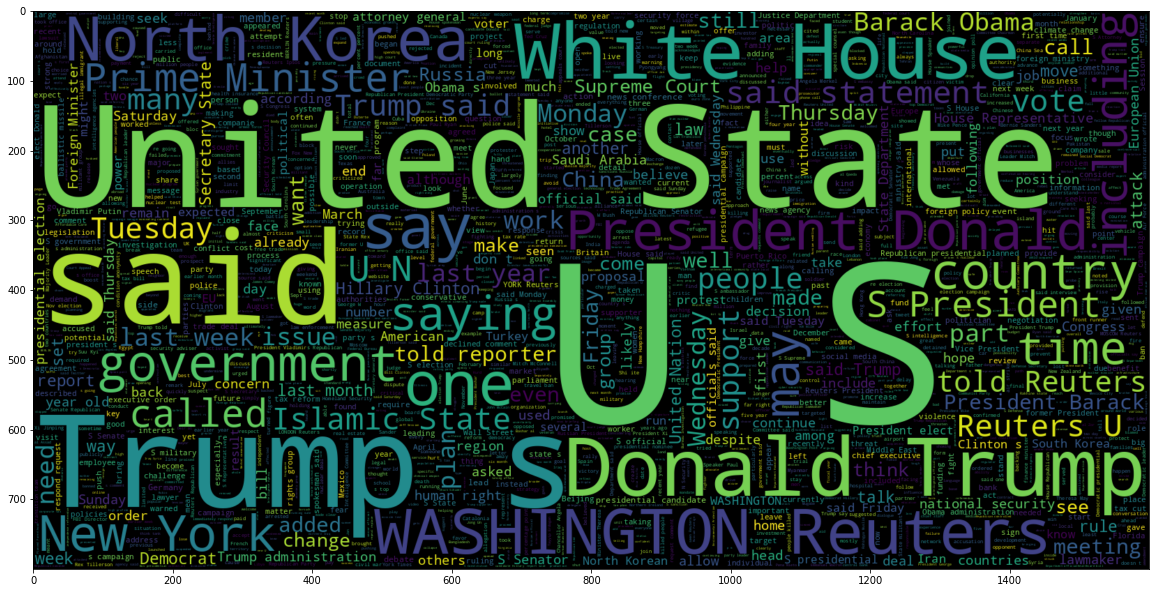

In [16]:
plt.figure(figsize = (20,20)) # Text that is not Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.label == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

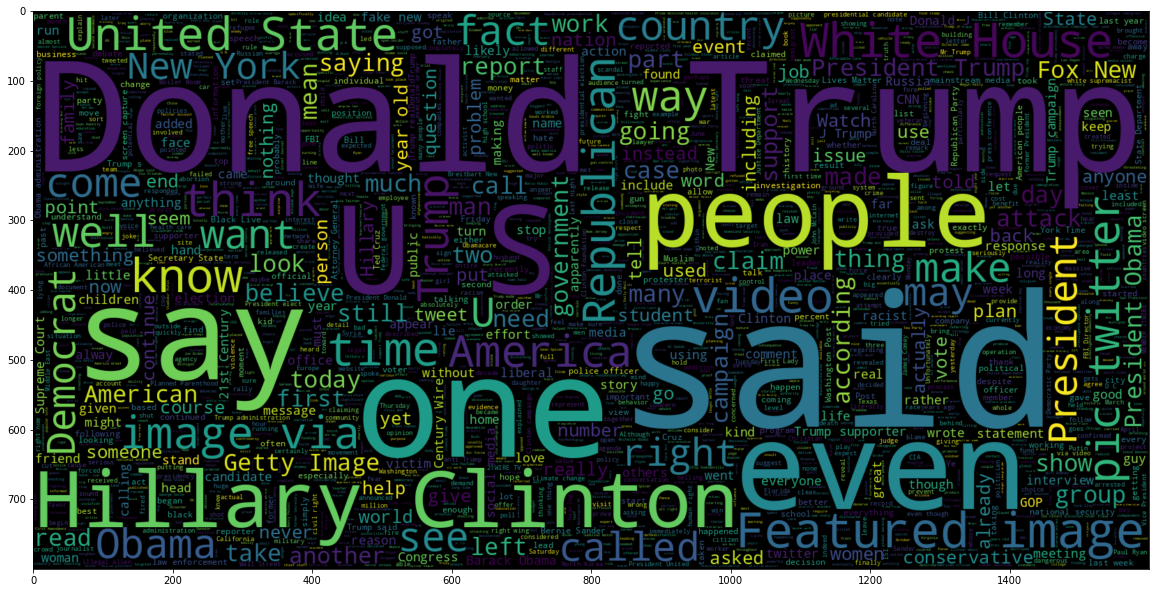

In [17]:
plt.figure(figsize = (20,20)) # Text that is Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.label == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

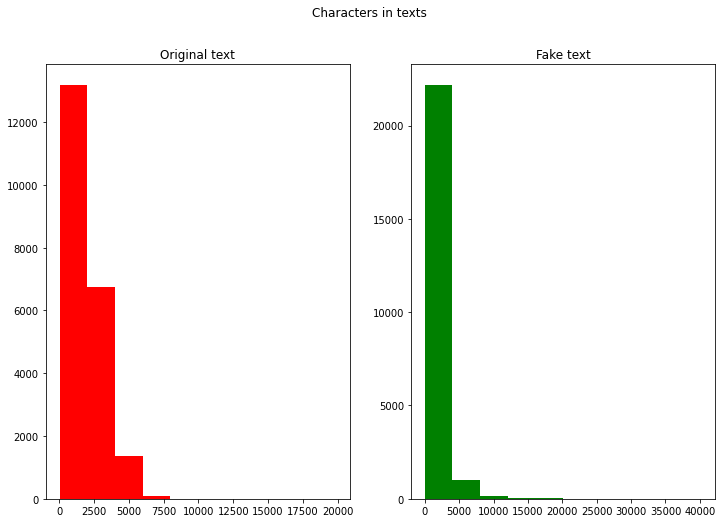

In [18]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=df[df['label']==1]['text'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('Original text')
text_len=df[df['label']==0]['text'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('Fake text')
fig.suptitle('Characters in texts')
plt.show()

In [19]:
from transformers import BertTokenizer
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [20]:
texts = df.text.values
labels = df.label.values

In [21]:
input_ids = []
attention_masks = []
for news in texts:
    encoded_dict = tokenizer.encode_plus(
                        news,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 512,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])
# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', texts[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  Donald Trump Sends Embarrassing New Year’s Eve Message; Disturbing Donald Trump wish Americans Happy New Year leave that. Instead, give shout enemies, haters dishonest fake news media. former reality show star one job it. Country rapidly grows stronger smarter, want wish friends, supporters, enemies, haters, even dishonest Fake News Media, Happy Healthy New Year, President Angry Pants tweeted. 2018 great year America! Country rapidly grows stronger smarter, want wish friends, supporters, enemies, haters, even dishonest Fake News Media, Happy Healthy New Year. 2018 great year America! Donald J. Trump (@realDonaldTrump) December 31, 2017Trump tweet went welll expect.What kind president sends New Year greeting like despicable, petty, infantile gibberish? Trump! lack decency even allow rise gutter long enough wish American citizens happy new year! Bishop Talbert Swan (@TalbertSwan) December 31, 2017no one likes Calvin (@calvinstowell) December 31, 2017Your impeachment would make

In [22]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size],generator=torch.Generator().manual_seed(42))

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

40,408 training samples
4,490 validation samples


In [23]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 16

train_dataloader = DataLoader(
            train_dataset,  
            shuffle = True,
            batch_size = batch_size 
        )

validation_dataloader = DataLoader(
            val_dataset,
            shuffle = False,
            batch_size = batch_size 
        )
     

In [24]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [25]:
device = torch.device('cpu')

# BERT Fine Tune

In [26]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 2, 
    output_attentions = False, 
    output_hidden_states = False,
)
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [27]:
optimizer = AdamW(model.parameters(),
                  lr = 5e-5, 
                  eps = 1e-8 
                )
epochs = 4
criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
import random
import numpy as np

seed_val = 42

random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
total_t0 = time.time()
best_accuracy = 0
for epoch_i in range(0, epochs):
    #Training
    print("")
    print('Epoch {:} / {:}'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_train_loss = 0
    total_train_accuracy = 0
    model.train()
    for step, batch in enumerate(train_dataloader):

        input_ids = batch[0].to(device)
        input_mask = batch[1].to(device)
        labels = batch[2].to(device)

        model.zero_grad()        
        out = model(input_ids, token_type_ids=None, attention_mask=input_mask, labels=labels)
        loss = out[0]
        logits = out[1]
  
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        pred = torch.argmax(logits, dim = 1)
        total_train_accuracy +=  torch.sum(pred == labels).item()
        
    avg_train_accuracy = total_train_accuracy / len(train_dataloader.dataset)
    avg_train_loss = total_train_loss / len(train_dataloader.dataset)            
    print("  Accuracy: {}".format(avg_train_accuracy))
    print("  Training loss: {}".format(avg_train_loss))
        

    # Validation
    print("")
    print("Validation...")
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    y_true = []
    y_pred = []

    for batch in validation_dataloader:
        input_ids = batch[0].to(device)
        input_mask = batch[1].to(device)
        labels = batch[2].to(device)
        
        with torch.no_grad():        
            out = model(input_ids, token_type_ids=None, attention_mask=input_mask,labels=labels)
            loss = out[0]
            logits = out[1]

        total_eval_loss += loss.item()
        pred = torch.argmax(logits, dim = 1)
        total_eval_accuracy += torch.sum(pred == labels).item()
        y_true.append(labels.flatten())
        y_pred.append(pred.flatten())
        
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader.dataset)
    print("  Accuracy: {}".format(avg_val_accuracy))
    avg_val_loss = total_eval_loss / len(validation_dataloader.dataset)
    print("  Validation loss: {}".format(avg_val_loss))
    training_time = format_time(time.time() - t0)
    print()
    
    y_true = torch.cat(y_true).tolist()
    y_pred = torch.cat(y_pred).tolist()
    print("This epoch took: {:}".format(training_time))
    print('roc_auc score: ', roc_auc_score(y_true,y_pred))
    print('F1 score:',f1_score(y_true, y_pred))
    print()

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Train Accur.': avg_train_accuracy,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
        }
    )
    print()

    if avg_val_accuracy > best_accuracy:
        best_accuracy = avg_val_accuracy
        best_model = model

print()
print("="*10)
print("Summary")
print("Total time {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


Epoch 1 / 4
Training...
